In [1]:
"""
Optimization Networks Example

The idea is to build optimization networks and structures in a similar fashion to
networks used in machine learning for fitting tasks, etc.
"""
import qutree
import importlib
importlib.reload(qutree)

from qutree import Grid, Objective
import numpy as np
from qutree.optimization import Model, variation_update, recombination_update
from qutree.optimization import create_mutations, recombination, maxvol_selection


def V(x):
    N = x.shape[0]
    v = 0.
    for i in range(N):
        v += 0.5*(x[i]+1.5)**2 + x[i]*x[(i+1) % N]
    return v


def pot(x):
    v = 0.
    for i in range(0, x.shape[0]):
        v += np.sin(np.pi*x[i]**2)/(x[i]**2+1e-7)
    for i in range(0, x.shape[0]):
        v+=np.sin(x[i]*x[i-1])
    return v - 15.


r, N, f, nsweep = 4, 21, 4, 3
# fun = ttopt_functions.brown
fun = pot


xs = np.array([[-0.5, -0.5, -0.5, -0.5],
              [-1.5, -1.5,  1.5, -1.5],
              [ 0.0,  0.0,  0.0,  0.0]])

primitive_grid = []
for k in range(f):
    primitive_grid.append(Grid(np.linspace(-4., 4., N), [k]))

grid = Grid(xs, [0, 1, 2, 3])


class SeparableModel(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            # print(f"k = {k}")
            # print(f"grid = {self.grid}")
            grid = variation_update(grid, self.primitive_grid[k], function, self.r, epoch = epoch)

        return grid


class StandardModel(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            grid = variation_update(grid, self.primitive_grid[k], function, self.r, epoch = epoch)
            if k > 0:
                idcs = list(range(k))
                grid = recombination_update(grid, idcs, function, r, epoch = epoch)

        return grid


class TTOpt(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            ngrid = create_mutations(grid, self.primitive_grid[k])
            if k > 0:
                idcs = list(range(k))
                ngrid = recombination(grid, idcs)
            maxvol_selection(ngrid, function, grid.num_points(), epoch = epoch)


obj = Objective(fun)

# model = SeparableModel()
model = StandardModel()
model.data(primitive_grid, r)
grid = model.optimize(grid, obj, 3)
print(grid)

print(obj)
print(obj.logger.df)


coords: [0 1 2 3]
grid:
[[-1.2  0.8 -2.   1.6]
 [-1.2  0.8 -2.  -1.2]
 [-1.2  0.8 -2.   0.8]]
Optimal value:
x1       -1.200000
x2        1.200000
x3       -1.200000
x4        1.200000
f       -21.694409
epoch     2.000000
Name: 564, dtype: float64

Number of objective function calls: 732
Number of cached function accesses: 105
Total number calls: 837
      x1   x2   x3   x4          f  epoch
0   -4.0 -0.5 -0.5 -0.5  -4.201319      0
1   -3.6 -0.5 -0.5 -0.5  -4.062548      0
2   -3.2 -0.5 -0.5 -0.5  -3.953917      0
3   -2.8 -0.5 -0.5 -0.5  -4.110463      0
4   -2.4 -0.5 -0.5 -0.5  -4.274681      0
..   ...  ...  ...  ...        ...    ...
727 -1.2  0.8  2.8  2.4 -14.319085      2
728 -1.2  0.8  2.8  2.8 -13.209546      2
729 -1.2  0.8  2.8  3.2 -13.206602      2
730 -1.2  0.8  2.8  3.6 -14.040342      2
731 -1.2  0.8  2.8  4.0 -14.347689      2

[732 rows x 6 columns]


Optimal value:
x1       0.0
x2       1.0
x3       2.0
x4       3.0
f        0.0
sweep    0.0
node     3.0
Name: 10, dtype: float64

Number of objective function calls: 429
Number of cached function accesses: 1521
Total number calls: 1950


,x1,x2,x3,x4,f,sweep,node
0,0.0,3.0,4.0,2.0,9.0,0,3
1,1.0,3.0,4.0,2.0,10.0,0,3
2,2.0,3.0,4.0,2.0,13.0,0,3
3,3.0,3.0,4.0,2.0,18.0,0,3
4,4.0,3.0,4.0,2.0,25.0,0,3
...,...,...,...,...,...,...,...
424,0.0,2.0,4.0,4.0,6.0,2,1
425,0.0,4.0,1.0,4.0,11.0,2,1
426,0.0,4.0,2.0,4.0,10.0,2,1
427,0.0,4.0,3.0,4.0,11.0,2,1


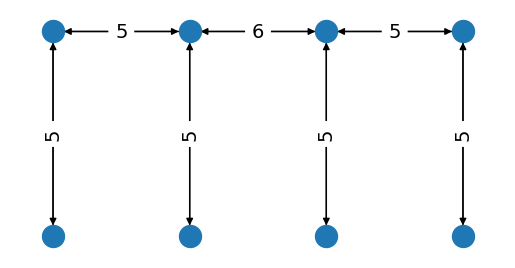

In [5]:
"""
Minimal example: optimize 3D V(x) with tensor train.
See next cell for balanced tree and how to provide starting points.
"""
from qutree import *

def V(x):
    # p = [1, 2, 3, ...]
    point = np.array(list(range(x.shape[0])))
    return np.sum((x-point)**2)

objective = Objective(V)

N, r, f, nsweeps, seed = 5, 6, 4, 3, 238141

# --- Pick a network structure: ---
G = tensor_train_graph(f, r, N)
fig = plot_tt_diagram(G)
# G = balanced_tree(f, r, N)
# fig = plot_tree(G)

# boundaries of primitive grid
primitive_grid = [np.linspace(0., 4., num = N)] * f

G_opt = ttnopt(G, objective, nsweeps, primitive_grid)

# Display output (can vary with random parameters)
print(objective)
display(objective.logger.df)